In [1]:
import math as ma
import numpy as np
import scipy as sc
import scipy.stats as st
import scipy.optimize 
import matplotlib as mpl
import matplotlib.pyplot as plt


In [4]:
def my_func(x, par):
    return par[0]*x**2+par[1]*x+par[2]
def my_func2(x, a, b, c):
    return a*x**2+b*x+c
def chisq(y, yfit, sigma):
    return sum(((np.asarray(y)-np.asarray(yfit))/sigma)**2)

Input Paramters:  [2, 3, 1]  MCMC estimate:  [1.97500739 3.67650895 0.57102911]  Curve fit:  [2.04705214 1.5402058  4.55927149]
109.05690269370717   201.67109436759614   110.6174443434641


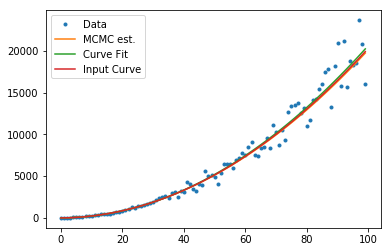

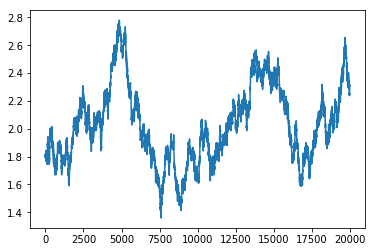

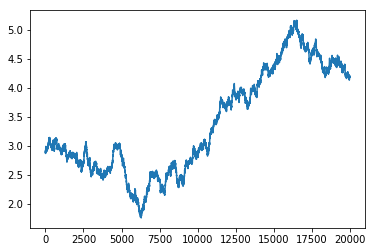

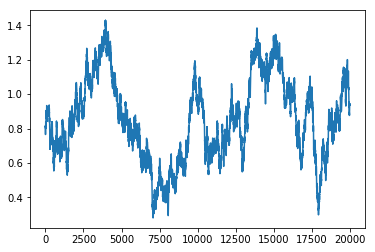

In [38]:
par = [2,3,1]
y = [my_func(i,par)*(1+np.random.normal(0,0.1)) for i in range(100)]
x = [i for i in range(100)]
sigma = [0.1*y[i] for i in range(100)]
sigma[0] = 1
sigma_mat = np.zeros((len(sigma),len(sigma)))
for i in x:
    sigma_mat[i][i] = sigma[i]
#print(sigma)
guess = [1.8,2.9,0.8]
yfit = [my_func(i,guess) for i in range(100)]
chisquare = chisq(y,yfit, sigma)
a = []
b = []
c = []
ch = []
xx = []
best = []
bestchsq = chisq(y,yfit, sigma)
for i in range(20000):
    pnew = np.asarray(guess) + np.random.normal(0,0.01,3)
    ynew = [my_func(i,pnew) for i in range(100)]
    chsqnew = chisq(y, ynew, sigma)
    uniform = np.random.uniform()
    if( uniform < chisquare/chsqnew):
        guess = pnew
        #print(i," ",uniform," ",chisquare," ",chsqnew," ",guess)
        chisquare = chsqnew
    if(bestchsq>chsqnew):
        bestchsq = chsqnew
        best = pnew.copy()
    a.append(guess[0])  
    b.append(guess[1])
    c.append(guess[2])
    xx.append(i)

ynew = [my_func(i,best) for i in range(100)]
plt.plot(x,y,'.',label='Data')
plt.plot(x,ynew,'-',label='MCMC est.')
fit, cov = sc.optimize.curve_fit(my_func2,x, y, sigma = sigma_mat)
print("Input Paramters: ",par, " MCMC estimate: ", best, " Curve fit: ", fit)
print(chisq(y,ynew,sigma)," ",chisq(y,yfit,sigma)," ",chisq(y,yinit,sigma))
yfit = [my_func(i,fit) for i in range(100)]
plt.plot(x,yfit,'-',label="Curve Fit")
yinit = [my_func(i,par) for i in range(100)]
plt.plot(x,yinit,'-',label="Input Curve")
plt.legend()
plt.show()
plt.plot(xx,a)
plt.show()
plt.plot(xx,b)
plt.show()
plt.plot(xx,c)
plt.show()


In [35]:
print(chisq(y,ynew,sigma)," ",chisq(y,yfit,sigma)," ",chisq(y,yinit,sigma))

83.24370917065858   81.21116391528238   83.29057787320556
